In [19]:
from main import *
import pickle

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ls ../SimulationResults/

adaptation_test.prof
adaptation_test_results_Ngens_100_Ncells_50.p
robustness_test.prof
robustness_test_results.p
robustness_test_results_Ngens_80_Ncells_40.p


In [44]:
# load simulation results

results_file = '../SimulationResults/robustness_test_results_Ngens_80_Ncells_40.p'

with open(results_file, 'rb') as f:
    results = pickle.load(f, encoding='latin1')

In [39]:
ls ../SimulationResults/

adaptation_test.prof
adaptation_test_results_Ngens_100_Ncells_50.p
robustness_test.prof
robustness_test_results.p
robustness_test_results_Ngens_80_Ncells_40.p


In [45]:
len(results)

80

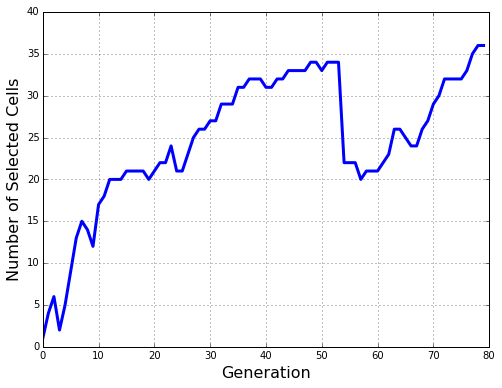

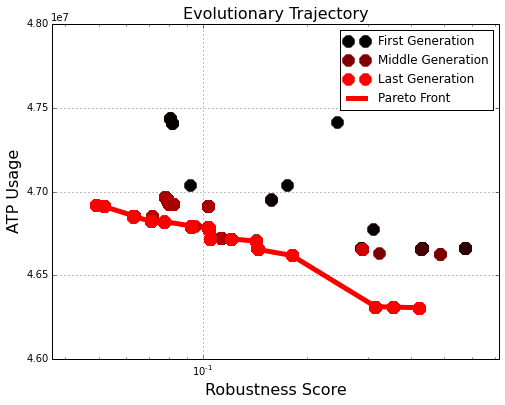

In [56]:
# plot population size
ax = plot_pareto_front_size(results)

# plot 2D evolutionary trajectory
ax = plot_2D_trajectory(results, obj=(0, 1), connect_front=True, labels=['Robustness Score', 'ATP Usage'])
ax.set_ylim(4.6e7, 4.8e7)
ax.set_yscale('linear')

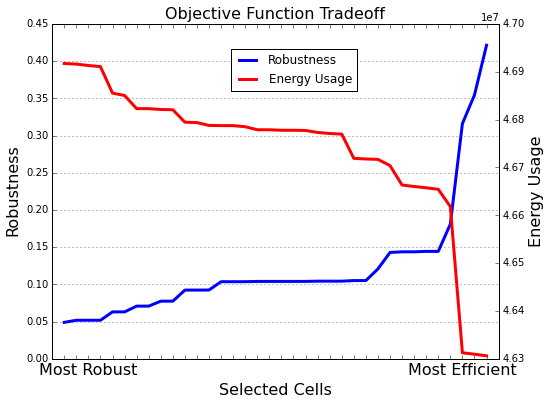

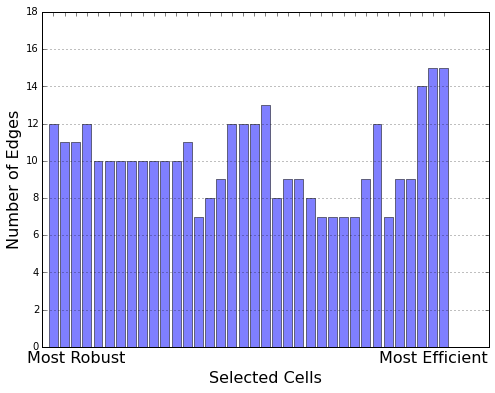

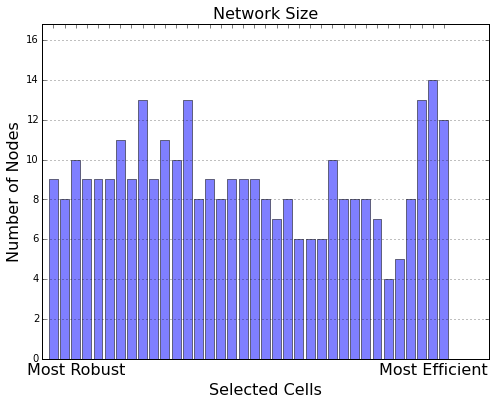

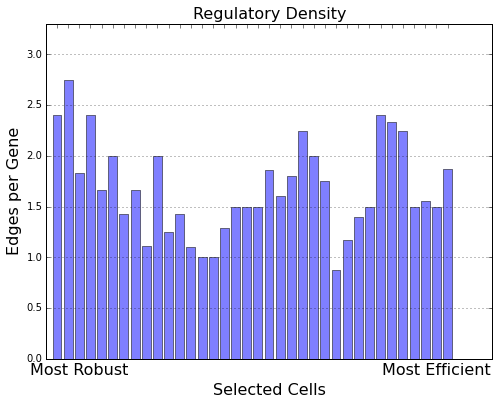

In [61]:
# get topological features from pareto front, ordered from most robust to most efficient
robustness, energy_usage, edge_count, node_count, edges_per_node, edges_per_gene = get_topology_from_front(results)
    
# plot edges vs position on pareto front

ax = plot_pareto_objective_tradeoff(metrics=[robustness, energy_usage], metric_names=['Robustness', 'Energy Usage'], plot_title='Objective Function Tradeoff')
    
# plot edges vs position on pareto front
ax = plot_metric(edge_count, 'Number of Edges')

# plot edges vs position on pareto front
ax1 = plot_metric(node_count, 'Number of Nodes', plot_title='Network Size')

# plot edges vs position on pareto front
ax2 = plot_metric(edges_per_gene, 'Edges per Gene', 'Regulatory Density')

In [60]:
# plot population size

def plot_pareto_front_size(results):
    ax = create_subplot_figure(dim=(1, 1), size=(8, 6))[0]
    ax.plot(list(results.keys()), [len(val) for val in results.values()], '-b', linewidth=3)
    ax.set_xlabel('Generation', fontsize=16)
    ax.set_ylabel('Number of Selected Cells', fontsize=16)
    return ax

def get_pareto_front(results):
    
    unordered_front = list(results.values())[-1]
    
    cells = unordered_front.keys() # list of unordered cells
    scores = unordered_front.values() # corresponding list of lists of scores
    
    # sort score and cell lists from left to right on first objective function axis
    
    scores, cells = zip(*sorted(zip(scores, cells), key = lambda x: x[0]))
    
        
    return cells, scores

def plot_pareto_objective_tradeoff(metrics, metric_names=['Objective 1', 'Objective 2'], plot_title=None):
    """
    Create bar plot of metric as a function of order along the pareto front.
    
    Parameters:
        metrics (list) - list of lists of metric values ordered by position on pareto front
    """
    
    # create axes
    ax = create_subplot_figure(dim=(1, 1), size=(8, 6))[0]
    ax2 = ax.twinx()
    
    # plot metric values
    ranks = np.arange(1, len(metrics[0])+1)
    ax.plot(ranks, metrics[0], '-b', linewidth=3)
    ax2.plot(ranks, metrics[1], '-r', linewidth=3)
    
    # add proxy artists
    ax.plot([], '-b', linewidth=3, label=metric_names[0])
    ax.plot([], '-r', linewidth=3, label=metric_names[1])
        
    # create bar plot, remove vertical grid and xtick marks
    ax.xaxis.grid(False)
    plt.tick_params(axis='x', which='both', bottom='off')

    # set tick labels as range from most robust to most efficient
    ax.set_xticks(ranks)
    tick_labels=ax.get_xticks().tolist()
    for i in range(0, len(tick_labels)):
        tick_labels[i] = ''
    tick_labels[2]='Most Robust'
    tick_labels[-3]='Most Efficient'
    ax.set_xlim(0, len(metrics[0])+1)
    ax.set_xticklabels(tick_labels, fontsize=16)    
    ax.set_xlabel('Selected Cells', fontsize=16)

    # label axes and figure
    ax.set_ylabel(metric_names[0], fontsize=16)
    ax2.set_ylabel(metric_names[1], fontsize=16)
    if plot_title is not None:
        ax.set_title(plot_title, fontsize=16) 
    ax.legend(loc=(0.4, 0.8))
    
    return ax

def plot_metric(metric, metric_name='Metric', plot_title=None):
    """
    Create bar plot of metric as a function of order along the pareto front.
    
    Parameters:
        metric (list) - list of metric values ordered by position on pareto front
    """
    
    # create axes
    ax = create_subplot_figure(dim=(1, 1), size=(8, 6))[0]
    
    # generate rank numbers
    ranks = np.arange(1, len(metric)+1)
        
    # create bar plot, remove vertical grid and xtick marks
    ax.bar(ranks, metric, align='center', alpha=0.5)
    ax.xaxis.grid(False)
    plt.tick_params(axis='x', which='both', bottom='off')
    
    # set tick labels as range from most robust to most efficient
    ax.set_xticks(ranks)
    tick_labels=ax.get_xticks().tolist()
    for i in range(0, len(tick_labels)):
        tick_labels[i] = ''
    tick_labels[2]='Most Robust'
    tick_labels[-2]='Most Efficient'
    ax.set_xticklabels(tick_labels, fontsize=16)    
    ax.set_xlabel('Selected Cells', fontsize=16)
    
    # label axes and figure
    ax.set_ylabel(metric_name, fontsize=16)
    if plot_title is not None:
        ax.set_title(plot_title, fontsize=16)
    
    ax.set_ylim(0, 1.2*max(metric))
    
    return ax

def get_topology_from_front(results):
    """
    Returns lists of topological metrics from the pareto front, ordered from highest robustness to highest efficiency.
    """

    # get ordered pareto front (cells ordered by first objective function score)
    cells, scores = get_pareto_front(results)
    
    # initialize lists
    robustness = []
    energy_usage = []
    edge_count = []
    node_count = []
    edges_per_node = []
    edges_per_gene = []

    # # for the future...
    # coherent_ff_loops = []
    # incoherent_ff_loops = []
    # fb_loops = []

    # store topological features of each cell on the pareto front
    for cell, score in zip(cells, scores):
        
        # get cell scores
        robustness.append(score[0])
        energy_usage.append(score[1])
        
        # get cell topology
        edges, nodes, key = cell.get_topology()

        # append number of edges
        edge_count.append(len(edges))
        node_count.append(len(nodes))

        # add edge density
        edges_per_node.append(len(edges)/len(nodes))
        edges_per_gene.append(len(edges)/ len([node for node, node_type in nodes.items() if node_type != 'modified protein']) )


    return robustness, energy_usage, edge_count, node_count, edges_per_node, edges_per_gene 

In [ ]:
# plot edges/gene vs rank on pareto front

# plot edge type count vs rank on pareto front


In [94]:
regulatory_edges, nodes, key = cell.get_topology()

print(nodes)

{0: 'permanent gene', 1: 'permanent gene', 2: 'removable gene', 3: 'removable gene', 4: 'non-coding gene', 5: 'non-coding gene', 6: 'non-coding gene', 7: 'modified protein'}


Reaction Type          Reactants    Enzymes    Products
---------------------  -----------  ---------  ----------
catalytic_degradation  [0]          [1]        []
modification           [1]          []         [10]
catalytic_degradation  [10]         [2]        []
modification           [0]          []         [11]
catalytic_degradation  [3]          [10]       []
catalytic_degradation  [1]          [10]       []
catalytic_degradation  [1]          [2]        []


Regulation Type      Target Gene    Transcription Factor
-----------------  -------------  ----------------------
activation                     0                       1
repression                     0                       2
repression                     0                      11
repression                     1                       0
activation                     0                       3
activation                     2                       5


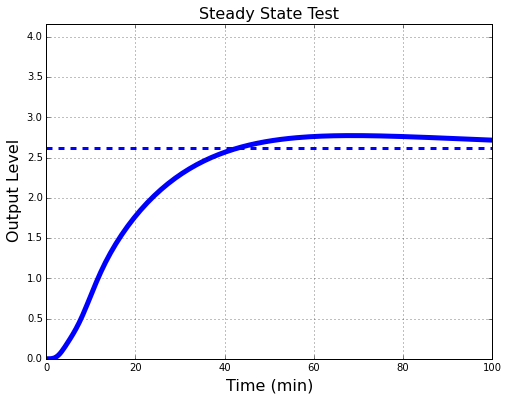

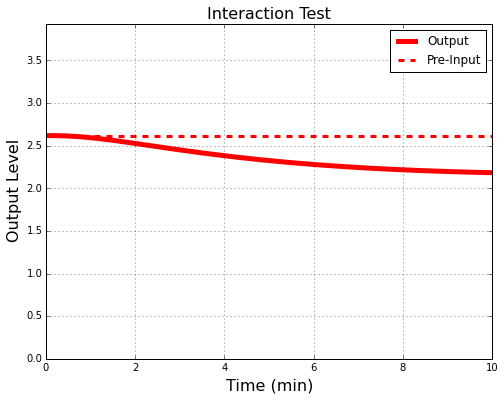

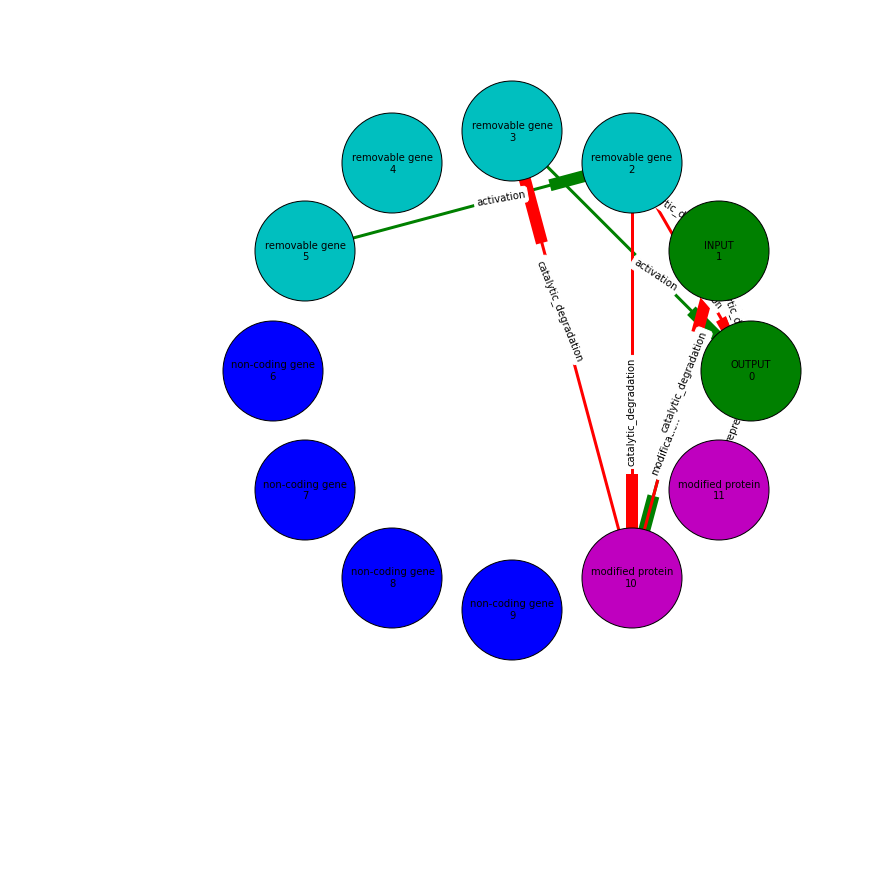

In [80]:
# select a cell from the population
cell_num = 0
cell = list(results[len(results)-1].items())[cell_num][0]

# check it's steady state simulation results
steady_states = cell.get_steady_states(input_node=2, input_magnitude=1)
cell.plot_steady_states(input_node=2, input_magnitude=1, output_node=1)
ax = plt.gca()
ax.plot([0, 100], [steady_states[cell.key[1]], steady_states[cell.key[1]]], '--b', linewidth=3, label='Steady State')

# check its interaction test results
_ = cell.interaction_check_numerical(input_node=2, output_node=1, steady_states=steady_states, plot=True)
ax = plt.gca()
ax.plot([0, 100], [steady_states[cell.key[1]], steady_states[cell.key[1]]], '--r', linewidth=3, label='Pre-Input')
ax.legend(loc=0)

# generate table of all reactions and modifications
cell.show_reactions(grn_indices=True)

# generate network graph
cell.show_topology(input_node=2, output_node=1)

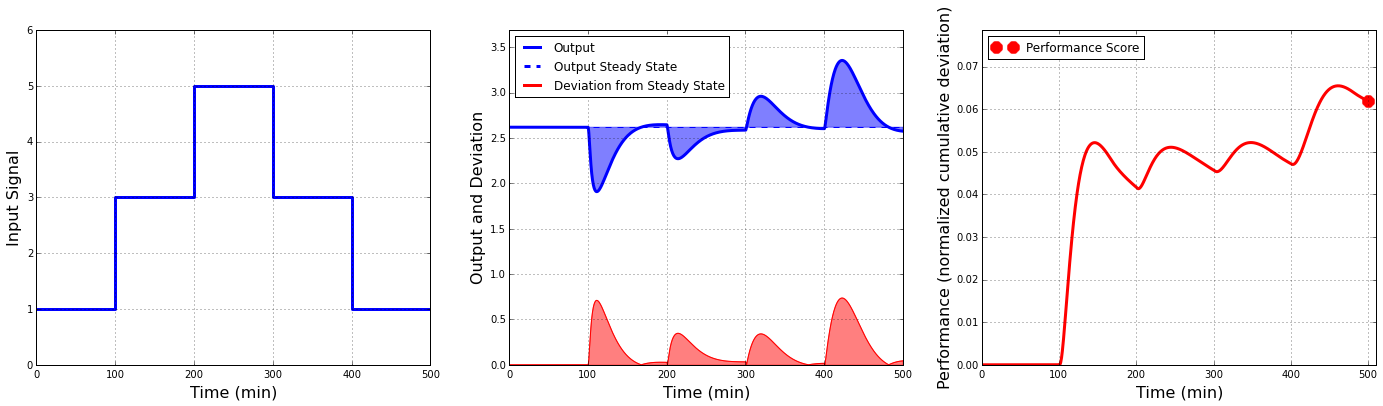

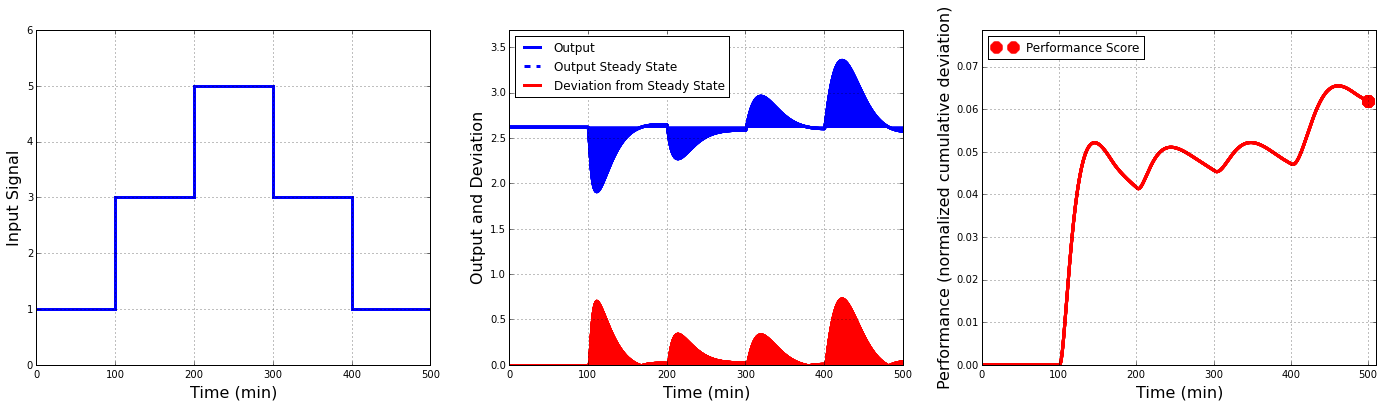

In [81]:
# run adaptation test
score, energy = adaptation_test(cell, input_node=2, output_node=1, input_random=False, plot=True)

# run robustness test
scores = robustness_test(cell, num_mutants=10, input_node=2, output_node=1, steady_states=None, plot=True)

In [64]:
scores

([0.048970358500644309, 46917420.236900821],
 [0.051787017823875257, 46916189.27441857],
 [0.051787082163763674, 46913248.178865202],
 [0.051787270247696512, 46910840.748943955],
 [0.063051293262096908, 46855486.077811718],
 [0.063053173993052852, 46850549.99615965],
 [0.07082112496929191, 46823069.617870487],
 [0.070822060495684847, 46823009.79625129],
 [0.077457528736538481, 46821308.938201174],
 [0.077459527214631535, 46820725.799221836],
 [0.092366999125582938, 46794647.805874266],
 [0.092368010092797229, 46793873.427558936],
 [0.092452617554221919, 46787887.353358448],
 [0.10364514481415114, 46787537.511798963],
 [0.10364598193529855, 46787523.280180268],
 [0.1036459945359649, 46785188.14019461],
 [0.1039954175952766, 46778879.676550001],
 [0.1039954175952766, 46778879.676550001],
 [0.10399903409958819, 46777818.019060358],
 [0.10400067468437184, 46777805.307993531],
 [0.10400568469271439, 46777338.33616478],
 [0.10433803498055036, 46773236.040744051],
 [0.10433918639507364, 46771

In [16]:
# import pickle

# with open('populations.p', 'wb') as f:
#     pickle.dump(populations, f)

In [63]:
cells, scores = get_pareto_front(results)

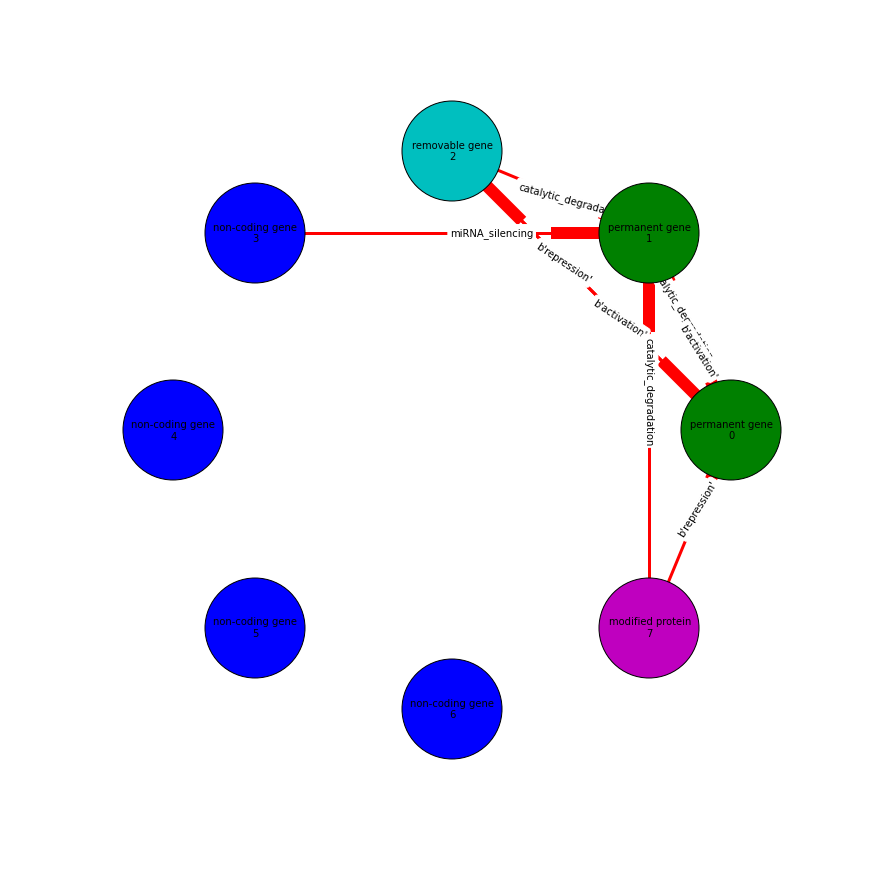

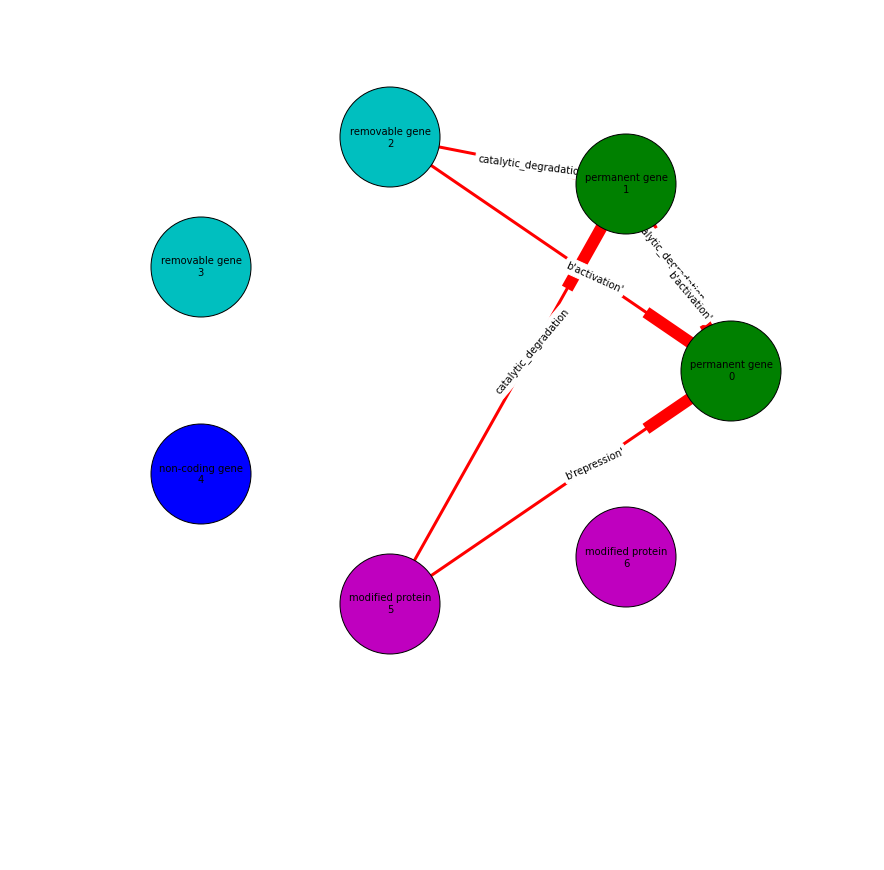

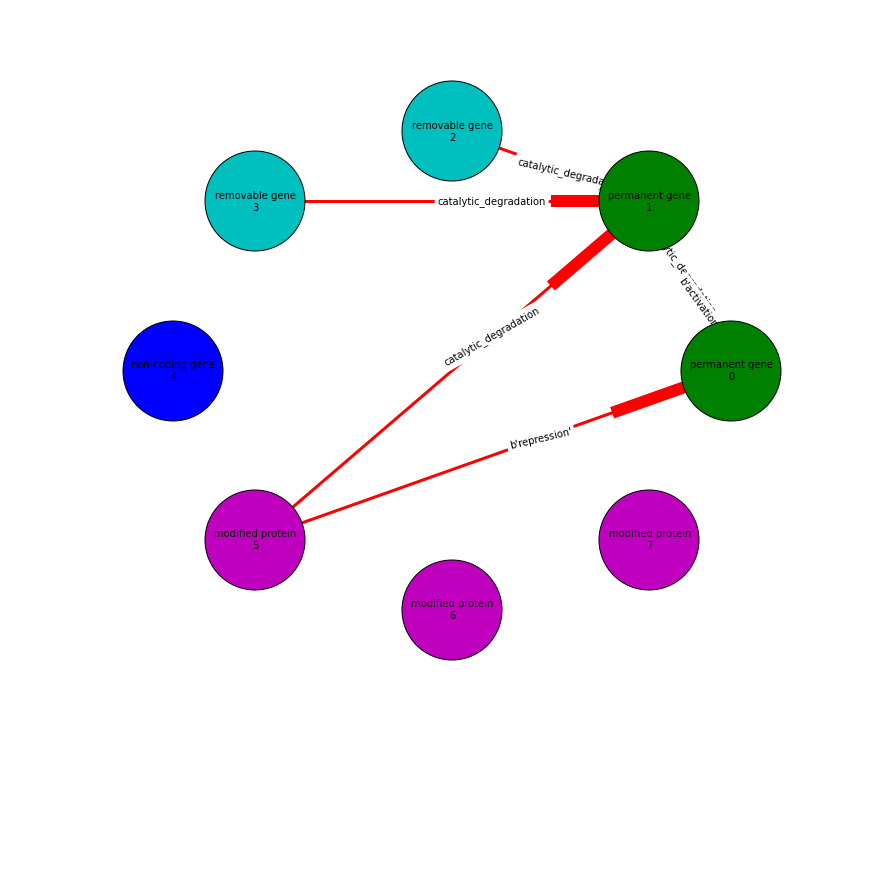

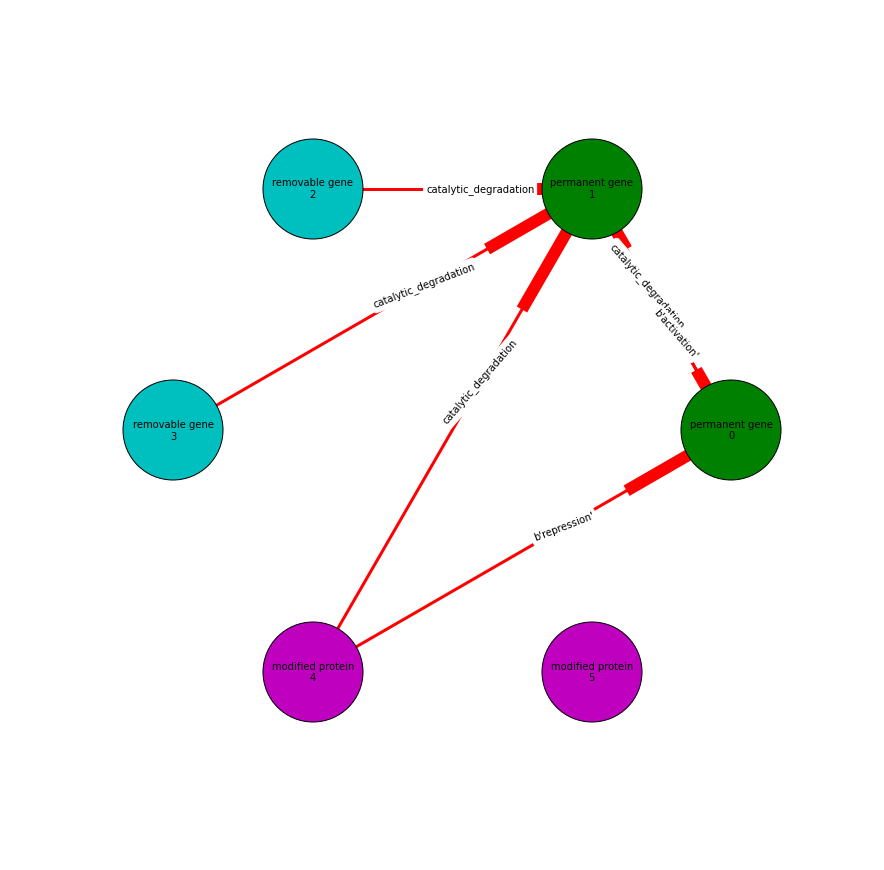

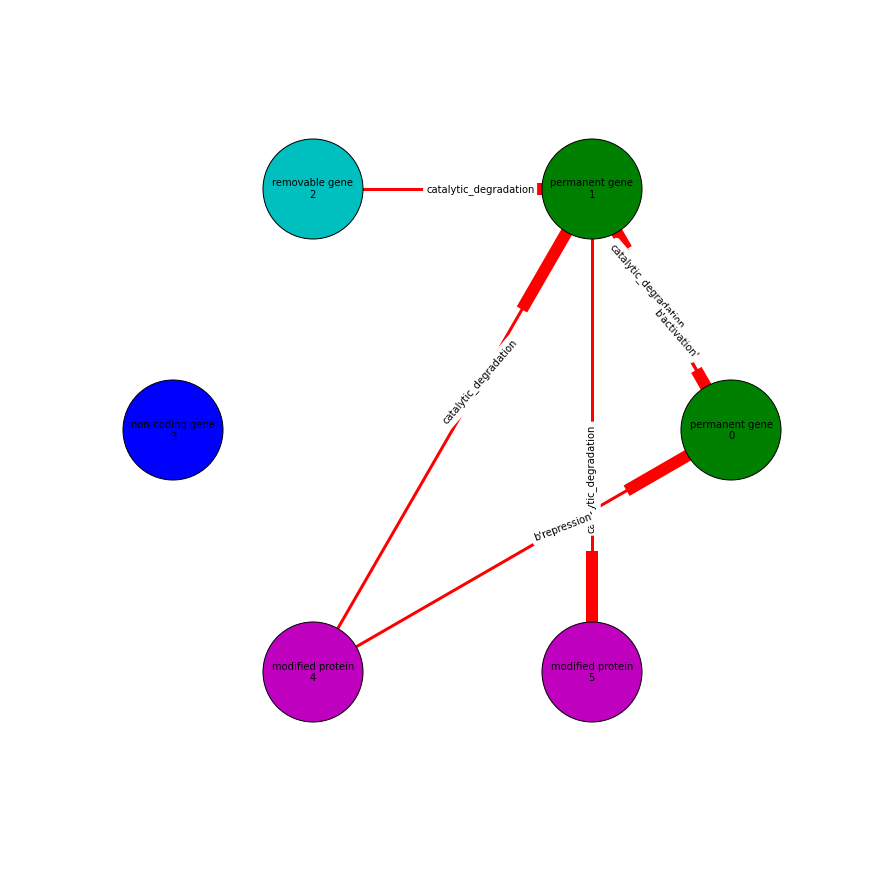

In [66]:
for cell in cells[19:24]:
    cell.show_topology()

In [68]:
cells[19].show_reactions(grn_indices=True)

Reaction Type              Reactants    Enzymes    Products
-------------------------  -----------  ---------  ----------
catalytic_degradation      [1]          [0]        []
b'catalytic_modification'  [0, 1]       []         [7]
catalytic_degradation      [1]          [7]        []
catalytic_degradation      [1]          [2]        []
catalytic_degradation      [1]          [2]        []
catalytic_degradation      [1]          [7]        []
miRNA_silencing            [3, 1]       []         []


Regulation Type      Target Gene    Transcription Factor
-----------------  -------------  ----------------------
activation                     0                       1
activation                     0                       2
repression                     0                       7
repression                     1                       1
repression                     2                       0
activation                     1                       1
repression                     2         